In [1]:
import gtfs_functions as gtfs
import matplotlib
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import random
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# cluster visualizer
#%matplotlib inline
#from yellowbrick.cluster import KElbowVisualizer 

# sklearn kmeans
from sklearn.metrics.cluster import contingency_matrix

# pyclustering kmeans
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster.encoder import cluster_encoder
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture

path_gtfs ='C:/Users/Maison/Documents/INFO-H423/Projet Data Mining/GTFS3sep/gtfs3sept.zip'

routes, stops, stop_times, trips, shapes = gtfs.import_gtfs(path_gtfs,busiest_date=False)
stop_freq = gtfs.stops_freq(stop_times, stops)
line_freq = gtfs.lines_freq(stop_times, trips, shapes, routes)

Bon ici j'ai du code illisible et flemme de documenter, je document à la fin les deux fonctions importantes

In [2]:
calendardf = pd.read_table('calendar.txt',sep=',')          #export the calendar file into data frame
calendarDatesdf = pd.read_table('calendar_dates.txt',sep=',')  #also export the exceptions

In [3]:
def FromDayToService(date):
    '''Determine all the service_id concerned by a date, given in the format date=('20210907','tuesday')
        it first take a look at every regular service_id then examine the exceptions. 
        Returns a list of service_id of type string'''

    ListServiceId=[]
    for i in range(len(calendardf)):
        startdate,endate=calendardf.iloc[i,[8,9]]
        if int(date[0]) in range(int(startdate),int(endate)+1):
            if calendardf.loc[i,date[1]]==1:
                #It appends every service_id which contains the date, and for which there is a '1'
                # under right day in the week
                ListServiceId.append(str(calendardf.iloc[i,0]))     

    #Now we have to take a look a the exceptions
    #We selections all the exceptions in calendarDatesdf that concerns the date in the input
    ModifServiceId= calendarDatesdf[calendarDatesdf['date']==int(date[0])][['service_id','exception_type']]
    #print('Number of service_id involved in modifications: '+ str(len(ModifServiceId)))
    #for every modif we check the kind of exception
    for modif in ModifServiceId.iterrows():  
        service = str(modif[1]['service_id'])
        exception = modif[1]['exception_type']
        if exception == 1:
            #if the exception is 1, it means that we should change to a 1 the cell related to the date in
            # input, in the row equal to service in calendar
            ListServiceId.append(service)
            #print('ServiceId: '+str(service)+' correclty added' )
        elif (exception == 2) & (service in ListServiceId):
            #if the exception is 2, it means that we should change to a 0 the cell related to the date in
            # input, in the row equal to service in calendar
            #Since this service_id must have been selected in the first loop (in Calendar), we need to remove it
            ListServiceId.remove(service)
            #print('ServiceId: '+str(service)+' correclty removed' )
        elif (exception == 2) & (service not in ListServiceId):
            #if the exception is 2 but we haven't found the service id in the first loop, this is weird
            #In principle this should not happend, but we're never too carefull
            print('Warning : exception 2 but no service_id = ' +service+ ' found in calendar')
    return (ListServiceId)

def FromLineIdtoRouteId(LineId):
    
    '''Takes a lineid in argument a returns the correspondent routeid, since stop_times only 
        contains route_id'''

    routeId = routes[routes['route_short_name']==LineId]['route_id'].iloc[0]
    return routeId

def ScheduledTime(date,routeid,stopId):

    '''Takes a triplet (date,lineId,stopId) with date in the format date=('20210907','tuesday')
        and returns the schedule for that triplet. The schedule is composed as follows: if we are in a period of
        punctuality then returns the (arrivaltime,true), and if we are in regularity, 
        returns (TimeOfWaitFromPreviousVehicle,False), all in one list '''

    ListOfService = pd.Series(FromDayToService(date))  #List of service_id tha apply for that day
    #RouteId = FromLineIdtoRouteId(lineId)               #We need the routeid to seek in the GTFS
    #We select the relevant rows in GTFS stop_times
    Scheduledf = stop_times[(stop_times['stop_id']==stopId)&(stop_times['route_id']==routeid)&(stop_times['service_id'].isin(ListOfService))].sort_values('arrival_time')
    ArrivalTime = Scheduledf['arrival_time'].values
    #print('Number of service_id involved: '+ str(len(ListOfService)))
    #We compute every wainting time to determine punctuality of regularity (< or > 720 s)
    #Schedule = list(ArrivalTime[1:]-ArrivalTime[:-1])
    IntervalTime = list(ArrivalTime[1:]-ArrivalTime[:-1])
    #Schedule.insert(0,ArrivalTime[0])
    #True if punctuality, False if regularity
    Punctuality = np.array(IntervalTime)>720 
    #Ultimately, if we are a punctuality, we want the arrival time and if we are in regularity, we want the 
    #time bewteen two vehicles
    for i,punctuality in enumerate(Punctuality):
        if punctuality:
            if (0<i<(len(Punctuality)-1)):
                if ~(Punctuality[i-1]) & ~(Punctuality[i+1]):
                    Punctuality[i]=False
            else:
                IntervalTime[i]=ArrivalTime[i]
 
    #Schedule = list(zip(Schedule,Punctuality))
    #The format is a list of tuples
    if len(IntervalTime)!=len(ArrivalTime[:-1]):
        print('Attention: la longueur de Schedule et ArrivalTime ne match pas dans ScheduledTime ')
    return IntervalTime,Punctuality,ArrivalTime[:-1]

def RouteIdToLineId(routeId):
    lineId = routes[routes['route_id']==routeId]['route_short_name'].iloc[0]
    return lineId

def TroncatedScheduleRegularity(date,routeid,stopId):
    Schedulemom = ScheduledTime(date,routeid,stopId)
    TroncatedInterval = [intervaltime for i,intervaltime in enumerate(Schedulemom[0]) if not(Schedulemom[1][i])]
    TroncatedArrival = [arrivaltime for i,arrivaltime in enumerate(Schedulemom[2]) if not(Schedulemom[1][i])]
    if len(TroncatedInterval)!= len(TroncatedArrival):
        print('Attention: la longueur de TroncatedInterval et TroncatedArrival ne match pas dans TroncatedScheduleRegularity ')
    return TroncatedInterval,TroncatedArrival


C'est ici que je fais le calcul pour trouver le stop_sequence du milieu pour chaque ligne et direction

In [4]:
StopTimesGroupTrip = stop_times.groupby('trip_id')[['stop_sequence']].mean().round()
StopTimesGroupTrip['stop_sequence']=StopTimesGroupTrip['stop_sequence'].astype(int)

StopTimesOnlyMeanSeq = pd.merge(stop_times, StopTimesGroupTrip, how='right', on= ['trip_id','stop_sequence'])
StopTimesOnlyMeanSeq = StopTimesOnlyMeanSeq[['route_id','stop_sequence','stop_id','direction_id']]
DicOfMiddleStop={}

for route in StopTimesOnlyMeanSeq['route_id'].unique():
    StopTimeMeanSeqRoute = StopTimesOnlyMeanSeq[StopTimesOnlyMeanSeq['route_id']==route]
    directionIds = StopTimeMeanSeqRoute['direction_id'].unique()
    for direction in directionIds:
        #Ici je prends la première valeure que je trouve qui a la bonne route et direction
        # car il peut y avoir plusieurs candidat Middle stop pour chaque (ligne,direction)
        # ici je prend le premier parce que j'en ai très exactement rien à fouttre
        stop = StopTimeMeanSeqRoute[StopTimeMeanSeqRoute['direction_id']==direction]['stop_id'].values[0]
        value = str(route)+':'+str(direction)
        if DicOfMiddleStop.get(stop) is None:
            DicOfMiddleStop[stop]=value


#Format du dico : 'middle_stop_id': 'routeid:direction'    Ex: '5510': '41:0'

#Ici c'est juste pour lui dire quelle date prendre en exemple si on dit 'weekday', 'satuday', etc...
DicOfWeek = {'weekday':('20210915','wednesday'),'saturday':('20210918','saturday'),'sunday':('20210919','sunday')}

#liste des middle stop
ListOfMiddleStop= list(DicOfMiddleStop.keys())

def get_key(val):
    for key, value in DicOfMiddleStop.items():
        if val == value:
            return key

    return None


Début d'un exemple de Clustering

Donc ici on a nos deux fonctions vraiment intéressantes, à savoir DataForCluster et DataForClusterDelta
L'idée de ces deux fonctions est qu'elle prenne en input une ligneid, un type de jour de semaine (soit 'weekday', soit 'saturday' soit 'sunday') et une direction (0 ou 1) et elles nous renvoie l'horaire (cleaned des points de ponctualités) de l'arrêt situé au milieu de cette ligne.
Plus précisément, le format de l'output pour DataForCluster est un dataframe avec une colonne 'ArrivalTime' et 'TimeWaited'
La deuxième fonction DataForClusterDelta est un peu différente, avec les mêmes inputs elle renvoie (en df) le temps d'arrivée d'un vehicle i et le temps d'arrivée du vehicle i+1, c'est ce que le prof avait conseillé de faire

In [5]:
def DataForCluster(routeid, directionid,dayoftheweek):
    key = get_key(str(routeid)+':'+str(directionid))
    if key!=None:
        middlestop = key
        dataCluster = TroncatedScheduleRegularity(DicOfWeek[dayoftheweek],routeid,middlestop)
        IntervalTime = dataCluster[0]
        ArrivalTime = dataCluster[1]
        df = pd.DataFrame({'ArrivalTime':ArrivalTime, 'TimeWaited':IntervalTime})
    return df

def DataForClusterDelta(routeid, directionid,dayoftheweek):
    key = get_key(str(routeid)+':'+str(directionid))
    if key!=None:
        middlestop = key
        dataCluster = TroncatedScheduleRegularity(DicOfWeek[dayoftheweek],routeid,middlestop)
        ArrivalTime = dataCluster[1]
        df = pd.DataFrame({'ArrivalTime_i':ArrivalTime[:-1], 'TimeWaited':ArrivalTime[1:]})
    return df

In [109]:
Data = DataForCluster('41','0','weekday')

On test ici avec le K-MEANS

In [110]:
nCluster = 6
#Quick test
# instatiate KMeans class and set the number of clusters
km_model = KMeans(n_clusters=nCluster, random_state=10)

# call fit method with data 
km = km_model.fit_predict(Data)

# coordinates of cluster center
centroids = km_model.cluster_centers_ 

# cluster label for each data point
labels = km_model.labels_ 

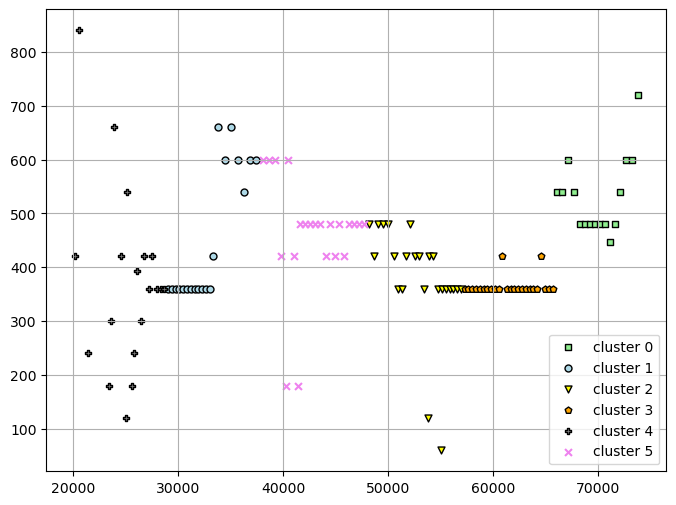

In [118]:
plt.figure(figsize=(8,6))
colors=['lightgreen','lightblue','yellow','orange','grey','violet']

markers=['s','o','v','p','P','x']

for n in range(nCluster):
    plt.scatter(
    Data[km == n]['ArrivalTime'], Data[km == n]['TimeWaited'],
    s=25, c= colors[n],
    marker= markers[n], edgecolor='black',
    label='cluster '+str(n)
    )


# visualise centroids

plt.legend(scatterpoints=1)
plt.grid()
plt.show()

On peut essayer avec un autre code qui permet de choisir la distance de k-means

In [33]:
# define dictionary for distance measures
distance_measures = {'euclidean': 0, 'squared euclidean': 1, 'manhattan': 2, 'chebyshev': 3, 
                    'canberra': 5, 'chi-square': 6}

# function defined to compute purity score using pyclustering for various distance measures
def Clustering(dist_measure,nclust,data):
    initial_centers = random_center_initializer(data.values, nclust, random_state=5).initialize()
    # instance created for respective distance metric
    instanceKm = kmeans(data.values, initial_centers=initial_centers, metric=distance_metric(dist_measure))
    # perform cluster analysis
    instanceKm.process()
    # cluster analysis results - clusters and centers
    pyClusters = instanceKm.get_clusters()
    pyCenters = instanceKm.get_centers()
    # enumerate encoding type to index labeling to get labels
    pyEncoding = instanceKm.get_cluster_encoding()
    pyEncoder = cluster_encoder(pyEncoding, pyClusters, data.values)
    pyLabels = pyEncoder.set_encoding(0).get_clusters()
    # function purity score is defined in previous section

    return(pyClusters,pyCenters)
    #return purity_score(IntervalTimeBetweenVehicle['TimeInterval'].values, pyLabels)

# print results
#for measure, value in distance_measures.items():
    #print(f"The purity score for {measure} distance is {round(pyPurity(value)*100, 2)}%")


In [116]:
Clusters = Clustering(distance_measures['manhattan'],6,Data)[0]
Centers = Clustering(distance_measures['manhattan'],6,Data)[1]

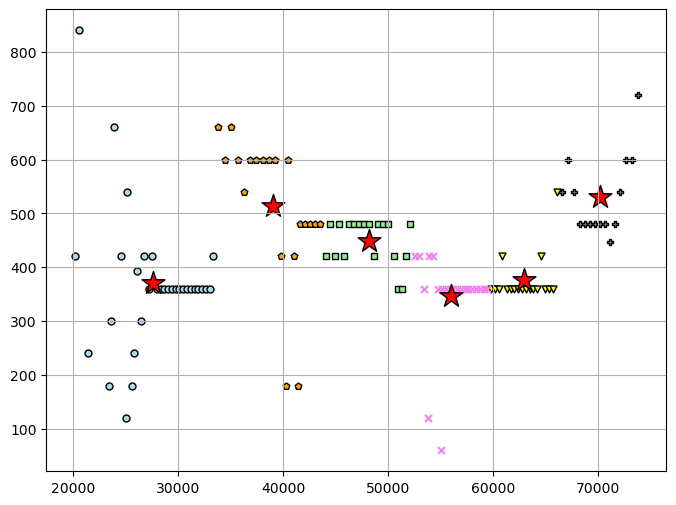

In [117]:
plt.figure(figsize=(8,6))

colors=['lightgreen','lightblue','yellow','orange','grey','violet','blue','red','magenta']

markers=['s','o','v','p','P','x','o','s']

for i,cluster in enumerate(Clusters):
    plt.scatter(
        Data.iloc[cluster,:1], Data.iloc[cluster,1:],
        s=25, c=colors[i],
        marker=markers[i], edgecolor='black',
        label='cluster '+str(i)
    )


# visualise centroids
for center in Centers:
    plt.scatter(
        center[0],center[1],
        s=300, marker='*',
        c='red', edgecolor='black',
        label='centroids'
    )
#plt.legend(scatterpoints=1)
plt.grid()
plt.show()

On peut aussi essayer de Cluster sur les arrival t_i et t_iplus1 de la fonction DataForCluster

In [122]:
DataDelta = DataForClusterDelta('7','0','weekday')
Clusters = Clustering(distance_measures['manhattan'],6,DataDelta)[0]
Centers = Clustering(distance_measures['manhattan'],6,DataDelta)[1]

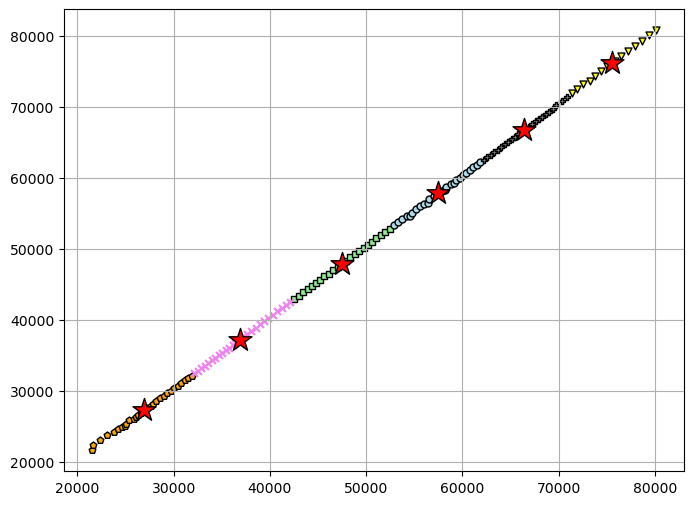

In [123]:
plt.figure(figsize=(8,6))

colors=['lightgreen','lightblue','yellow','orange','grey','violet','blue','red','magenta']

markers=['s','o','v','p','P','x','o','s']

for i,cluster in enumerate(Clusters):
    plt.scatter(
        DataDelta.iloc[cluster,:1], DataDelta.iloc[cluster,1:],
        s=25, c=colors[i],
        marker=markers[i], edgecolor='black',
        label='cluster '+str(i)
    )


# visualise centroids
for center in Centers:
    plt.scatter(
        center[0],center[1],
        s=300, marker='*',
        c='red', edgecolor='black',
        label='centroids'
    )
#plt.legend(scatterpoints=1)
plt.grid()
plt.show()

On peut regarder ce que ce cluster donne sur le graphique initial (attention)

In [124]:
DataInit = DataForCluster('7','0','weekday')
DataInit.drop(0,axis=0,inplace=True)

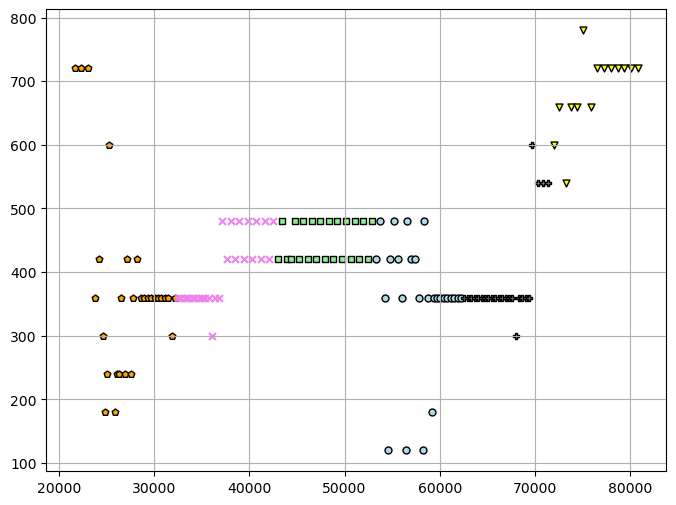

In [125]:
plt.figure(figsize=(8,6))

colors=['lightgreen','lightblue','yellow','orange','grey','violet','blue','red','magenta']

markers=['s','o','v','p','P','x','o','s']

for i,cluster in enumerate(Clusters):
    plt.scatter(
        DataInit.iloc[cluster,:1], DataInit.iloc[cluster,1:],
        s=25, c=colors[i],
        marker=markers[i], edgecolor='black',
        label='cluster '+str(i)
    )


# visualise centroids

#plt.legend(scatterpoints=1)
plt.grid()
plt.show()

Très similaire au Cluster précédent 

Maintenant qu'on sait comment ça marche lessgo on attaque l'écriture d'un CSV

In [28]:
ListOfStopId  = list(stop_times['stop_id'].unique())
DicOfStopInRoute = {}
for route in routes['route_id']:
    ListOfStop = [stop for stop in stop_times[stop_times['route_id']==route]['stop_id'].unique()]
    DicOfStopInRoute[route]=ListOfStop

In [31]:
import csv  

header = ['route_id','stop_id','Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5','Cluster6']

In [35]:
#code qui fait du clustering et détermine les times group pour chaque arrêt

with open('TimeGroupWeekdayAllStop.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    # write the data
    k=0
    l=1
    for route in DicOfStopInRoute:
        for stop in DicOfStopInRoute[route]:
            DataTemp = TroncatedScheduleRegularity(('20210915','wednesday'),route,stop)
            IntervalTime = DataTemp[0]
            ArrivalTime = DataTemp[1]
            Data = pd.DataFrame({'ArrivalTime':ArrivalTime, 'TimeWaited':IntervalTime})
            if len(Data)>6:
                Clusters = Clustering(distance_measures['manhattan'],6,Data)[0]
                Clusters.sort(key=lambda x: x[0])
                row = [route,stop]
                for cluster in Clusters:
                    rangeCluster = str(Data.iloc[cluster[0],0])+'::'+str(Data.iloc[cluster[-1],0])
                    row.append(rangeCluster)
                writer.writerow(row)
        k+=1
        if k==5:
            print(str(k*l)+' route encodées')
            l+=1
            k=0
        
    

KeyboardInterrupt: 

In [126]:
reader = csv.reader(open('Schedule20210915.csv', 'r'),delimiter=',')
Clusterdf = pd.read_csv('TimeGroupWeekday.csv')
header = ['route_id','direction','stop_id','Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5','Cluster6']

#Fonction pour lire le CSV JSON

with open('ClassifiedRegularityPointInJson.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    # write the data
    k=0
    l=1
    for row in reader:
        if len(row)>5:
            route = int(row[0])
            if len(row[1])>0:
                direction = int(row[1][1])
            else:
                direction = 'NotFound'
            stop = row[2]
            RangeClusterInvolved = Clusterdf[(Clusterdf['route_id']==route) & (Clusterdf['direction_id']==direction) ][['Cluster1','Cluster2','Cluster3','Cluster4','Cluster5','Cluster6']].values
            if len(RangeClusterInvolved)>0:
                RangeClusterInvolved = [RangeClust.split('::') for RangeClust in RangeClusterInvolved[0]]
                ArrivalTime = np.array([float(arrival) for arrival in row[3:]])
                IntervalTime = ArrivalTime[1:]-ArrivalTime[:-1]
                RowToWrite=[route,direction,stop]
                for rangecluster in RangeClusterInvolved:
                    borneinf = float(rangecluster[0])
                    bornesup = float(rangecluster[1])
                    DataInCluster = []
                    for i,interval in enumerate(IntervalTime):
                        if (borneinf<ArrivalTime[i]) & (ArrivalTime[i]<=bornesup):
                            DataInCluster.append(interval)
                    #DataInCluster = [IntervalTime[i] for i in range(len(IntervalTime))] #if (borneinf<ArrivalTime[i]) & (ArrivalTime[i]<=bornesup) ]
                    RowToWrite.append(DataInCluster)
                writer.writerow(RowToWrite)
            
        k+=1
        if k==100:
            print(str(k*l)+' arrêt encodées')
            l+=1
            k=0

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
100 arrêt encodées
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
200 arrêt encodées
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
300 arrêt encodées
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
400 arrêt encodées
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
500 arrêt encodées
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
600 arrêt encodées
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
700 arrêt encodées
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
800 arrêt encodées
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
900 arrêt encodées

In [87]:
#Code initial pour CSV timegroup

with open('TimeGroupWeekdayAllStop.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    # write the data
    k=0
    l=1
            
    for stop in ListOfMiddleStop:
        value = DicOfMiddleStop[stop].split(':')
        routeid=value[0]
        directionid = value[1]
        DataTemp = TroncatedScheduleRegularity(('20210915','wednesday'),routeid,stop)
        IntervalTime = DataTemp[0]
        ArrivalTime = DataTemp[1]
        Data = pd.DataFrame({'ArrivalTime':ArrivalTime, 'TimeWaited':IntervalTime})
        if len(Data)>6:
            Clusters = Clustering(distance_measures['manhattan'],6,Data)[0]
            Clusters.sort(key=lambda x: x[0])
            row = [routeid,directionid,stop]
            for cluster in Clusters:
                rangeCluster = str(Data.iloc[cluster[0],0])+'::'+str(Data.iloc[cluster[-1],0])
                row.append(rangeCluster)
            writer.writerow(row)
        k+=1
        if k==10:
            print(str(k*l)+' stop_id traités')
            l+=1
            k=0


10 stop_id traités
20 stop_id traités
30 stop_id traités
40 stop_id traités
50 stop_id traités
60 stop_id traités
70 stop_id traités
80 stop_id traités
90 stop_id traités
100 stop_id traités
110 stop_id traités
120 stop_id traités
130 stop_id traités
140 stop_id traités
150 stop_id traités
160 stop_id traités
170 stop_id traités
180 stop_id traités
190 stop_id traités


On test ici avec le DBSCAN

In [54]:
db = DBSCAN(eps=821, min_samples=4).fit(Data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

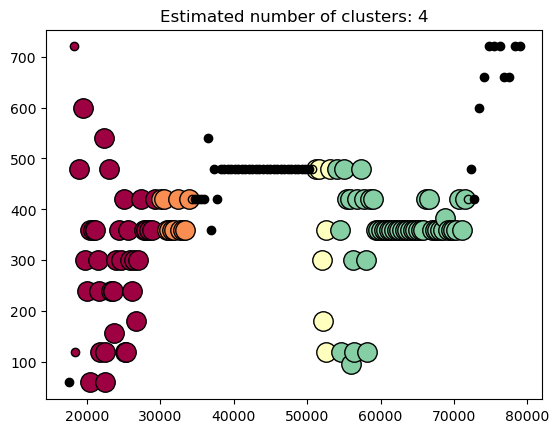

In [55]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colorsDBSCAN = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colorsDBSCAN):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = Data[class_member_mask & core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )
    xy = Data[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )
    

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

Vraiment pas concluant,  assez  dur de trouver les bons paramètres
On peut essayer de faire du progressive DBSCAN, et voir quel paramètre nous donne x cluster

In [56]:
EpsRange = np.linspace(100,12000,100)
ClusterDic={}

for Eps in EpsRange:
       for minsample in range(1,100):
              db = DBSCAN(eps=Eps, min_samples=minsample).fit(Data)
              core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
              core_samples_mask[db.core_sample_indices_] = True
              labels = db.labels_
              n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
              n_noise_ = list(labels).count(-1)
              key = str(Eps)+':'+str(minsample)
              ClusterDic[key] = n_clusters_

In [58]:
n_cluster_wanted = 6
value = {i for i in ClusterDic if ClusterDic[i]==n_cluster_wanted}
#format 'EpsRange:Minsample'
value

{'580.8080808080808:4'}

In [59]:
db = DBSCAN(eps=580, min_samples=4).fit(Data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

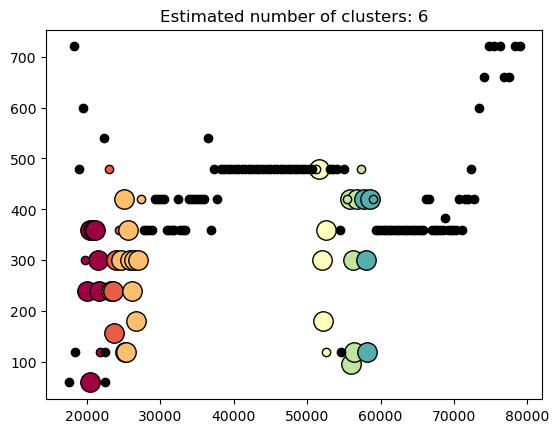

In [60]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colorsDBSCAN = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colorsDBSCAN):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = Data[class_member_mask & core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )
    xy = Data[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )
    

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

Bcp de point ne sont pas repris...

Brouillon Pierre

In [ ]:


def RawScheduledTime(date,lineId,stopId):

    '''Takes a triplet (date,lineId,stopId) with date in the format date=('20210907','tuesday')
        and returns the schedule for that triplet. The schedule is composed as follows: if we are in a period of
        punctuality then returns the (arrivaltime,true), and if we are in regularity, 
        returns (TimeOfWaitFromPreviousVehicle,False), all in one list '''

    ListOfService = pd.Series(FromDayToService(date))  #List of service_id tha apply for that day
    RouteId = FromLineIdtoRouteId(lineId)               #We need the routeid to seek in the GTFS
    #We select the relevant rows in GTFS stop_times
    Scheduledf = stop_times[(stop_times['stop_id']==stopId)&(stop_times['route_id']==RouteId)&(stop_times['service_id'].isin(ListOfService))].sort_values('arrival_time')
    ArrivalTime = Scheduledf['arrival_time'].values
    #print('Number of service_id involved: '+ str(len(ListOfService)))
    #We compute every wainting time to determine punctuality of regularity (< or > 720 s)
    IntervalTime = list(ArrivalTime[1:]-ArrivalTime[:-1])
    #IntervalTime.insert(0,ArrivalTime[0])
    df = pd.DataFrame({'ArrivalTime':ArrivalTime[1:], 'TimeWaited':IntervalTime})
    return df

def DeltaTimeCompar(date,lineId,stopId):

    '''Takes a triplet (date,lineId,stopId) with date in the format date=('20210907','tuesday')
        and returns the schedule for that triplet. The schedule is composed as follows: if we are in a period of
        punctuality then returns the (arrivaltime,true), and if we are in regularity, 
        returns (TimeOfWaitFromPreviousVehicle,False), all in one list '''

    ListOfService = pd.Series(FromDayToService(date))  #List of service_id tha apply for that day
    RouteId = FromLineIdtoRouteId(lineId)               #We need the routeid to seek in the GTFS
    #We select the relevant rows in GTFS stop_times
    Scheduledf = stop_times[(stop_times['stop_id']==stopId)&(stop_times['route_id']==RouteId)&(stop_times['service_id'].isin(ListOfService))].sort_values('arrival_time')
    ArrivalTime = Scheduledf['arrival_time'].values
    #print('Number of service_id involved: '+ str(len(ListOfService)))
    #We compute every wainting time to determine punctuality of regularity (< or > 720 s)
    IntervalTime = list(ArrivalTime[1:]-ArrivalTime[:-1])
    IntervalTime_i = IntervalTime[:-1]
    IntervalTime_iplus1 = IntervalTime[1:]
    #IntervalTime.insert(0,ArrivalTime[0])
    df = pd.DataFrame({'IntervalTimei':IntervalTime_i, 'IntervalTimeiplus1':IntervalTime_iplus1})
    return df


In [ ]:
plt.figure(figsize=(8,6))
colors=['lightgreen','lightblue','yellow','orange','grey','violet']

markers=['s','o','v','p','P','x']

for n in range(nCluster):
    plt.scatter(
    Data[km == n]['Vehicle_i'], Data[km == n]['Vehicle_iPlus1'],
    s=25, c= colors[n],
    marker= markers[n], edgecolor='black',
    label='cluster '+str(n)
    )


# visualise centroids
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    s=300, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [27]:
ListOfStopId  = list(stop_times['stop_id'].unique())
DicOfStopInRoute = {}
for route in routes['route_id']:
    ListOfStop = [stop for stop in stop_times[stop_times['route_id']==route]['stop_id'].unique()]
    DicOfStopInRoute[route]=ListOfStop

In [15]:
def ScheduledTimeCSV(date,routeid,stopId):

    '''Takes a triplet (date,lineId,stopId) with date in the format date=('20210907','tuesday')
        and returns the schedule for that triplet. The schedule is composed as follows: if we are in a period of
        punctuality then returns the (arrivaltime,true), and if we are in regularity, 
        returns (TimeOfWaitFromPreviousVehicle,False), all in one list '''

    ListOfService = pd.Series(FromDayToService(date))              #We need the routeid to seek in the GTFS
    #We select the relevant rows in GTFS stop_times
    Scheduledf = stop_times[(stop_times['stop_id']==stopId)&(stop_times['route_id']==routeid)&(stop_times['service_id'].isin(ListOfService))].sort_values('arrival_time')
    directionId = Scheduledf['direction_id'].unique()
    ArrivalTime = Scheduledf['arrival_time'].values
    

    return ArrivalTime,directionId

In [17]:
import csv  

headerSchedule = ['route_id','direction_id','stop_id','ArrivalTime']

In [ ]:
for i,route in enumerate(DicOfStopInRoute):
    for stop in DicOfStopInRoute[route]:
        ArrivalTime,directionId = ScheduledTimeCSV(('20210915','wednesday'),route,stop)
        row = [route,directionId,stop]
        row.extend(ArrivalTime)

In [26]:
with open('Schedule20210915.csv', 'w', encoding='UTF8') as f:
    #writer = csv.writer(f)
    # write the header
    #writer.writerow(headerSchedule)
    k=0
    l=1
    for route in DicOfStopInRoute:
        for stop in DicOfStopInRoute[route]:
            ArrivalTime,directionId = ScheduledTimeCSV(('20210915','wednesday'),route,stop)
            row = [route,directionId,stop]
            row.extend(ArrivalTime)
            #writer.writerow(row)
        k+=1
        if k==5:
            print(str(k*l)+' lignes encodées')
            l+=1
            k=0
        



5 lignes encodées
10 lignes encodées
15 lignes encodées
20 lignes encodées
25 lignes encodées
30 lignes encodées
35 lignes encodées
40 lignes encodées
45 lignes encodées
50 lignes encodées
55 lignes encodées
60 lignes encodées
65 lignes encodées
70 lignes encodées
75 lignes encodées
80 lignes encodées
85 lignes encodées
90 lignes encodées
95 lignes encodées


In [24]:
isinstance(31%10)

TypeError: isinstance expected 2 arguments, got 1